In [1]:
# Load all necessary packages
import sys
sys.path.append("../")
from aif360.algorithms.preprocessing.distributional_repair import DistributionalRepair
# from aif360.algorithms.preprocessing.pointwise_repair import PointwiseRepair

from aif360.datasets import AdultDataset, CompasDataset
import numpy as np
import pandas as pd
import ot
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

from tqdm import tqdm

import time

C:\Users\01joh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


## Loading Datasets

Using the AIF360 inbuilt methods for loading datasets, the adult dataset and compas datasets can be loaded as shown below. This can be adapted for use with other datasets, both existing and custom.

In [2]:
def load_adult_dataset(s,u,x,y, additional_cols = []):
    def custom_preprocessing(df):
        pd.set_option('future.no_silent_downcasting', True)
        def group_race(x):
            if x == "White":
                return 1.0
            else:
                return 0.0

        df['race'] = df['race'].apply(lambda x: group_race(x))

        # Encode 'sex' column as numerical values
        df['sex'] = df['sex'].map({'Female': 0.0, 'Male': 1.0})

        df['Income Binary'] = df['income-per-year']
        df['Income Binary'] = df['Income Binary'].replace(to_replace='>50K.', value=1, regex=True)
        df['Income Binary'] = df['Income Binary'].replace(to_replace='>50K', value=1, regex=True)
        df['Income Binary'] = df['Income Binary'].replace(to_replace='<=50K.', value=0, regex=True)
        df['Income Binary'] = df['Income Binary'].replace(to_replace='<=50K', value=0, regex=True)
        # 1 if education-num is greater than 9, 0 otherwise
        df['college_educated'] = (df['education-num'] > 9).astype(int)

        #drop nan columns
        df = df.dropna()

        return df

    adult = AdultDataset(
        label_name=y,
        favorable_classes=[1,1],
        protected_attribute_names=[s],
        privileged_classes=[[1.0]],
        instance_weights_name=None,
        categorical_features=[],
        features_to_keep=[s]+[u]+x+additional_cols,
        na_values=[],
        custom_preprocessing=custom_preprocessing,
        features_to_drop=[],
        metadata={}
    )
    return adult

def load_compas_dataset(s,u,x,y):
    def custom_preprocessing(df):
        #print the length of the dataframe
        # Convert 'c_charge_degree' to numeric values
        charge_degree_map = {'M': 0, 'F': 1}  # Map 'M' to 0 and 'F' to 1
        df['c_charge_degree'] = df['c_charge_degree'].map(charge_degree_map)

        # Map 'Caucasian' to 1 and all other values to 0
        df['race'] = df['race'].apply(lambda x: 1 if x == 'Caucasian' else 0)

        df['sex'] = df['sex'].apply(lambda x:1 if x == "Female" else 0)
        return df

    compas = CompasDataset(
        label_name=y,
        favorable_classes=[1,1],
        protected_attribute_names=[s],
        privileged_classes=[[1.0]],
        instance_weights_name=None,
        categorical_features=[],
        features_to_keep=[s]+[u]+x,
        na_values=[],
        custom_preprocessing=custom_preprocessing,

        metadata={}
    )

    return compas


## Kullback-Leibler Divergence (KLD)
The performance of the repair is evaluated using the Kullback-Leibler Divergence (KLD) metric. The KLD is a measure of how one probability distribution diverges from a second, expected probability distribution. In this case, the KLD is used to measure the divergence between the original and repaired datasets. The KLD is calculated for each feature in the dataset, in order to provide a comprehensive evaluation of the repair.

In [3]:
def _eval_kld(x_0, x_1):
    support = np.linspace(np.min([np.min(x_0), np.min(x_1)]), np.max([np.max(x_0), np.max(x_1)]), 500).reshape(-1,1)
    kde_0 = KernelDensity(kernel='gaussian',bandwidth='silverman').fit(x_0.reshape(-1,1))
    pmf_0 = np.exp(kde_0.score_samples(support)) 
    #add a small value to avoid division by zero
    pmf_0 += 1e-10
    kde_1 = KernelDensity(kernel='gaussian',bandwidth='silverman').fit(x_1.reshape(-1,1))
    pmf_1 = np.exp(kde_1.score_samples(support))
    pmf_1 += 1e-10
    return - np.sum(pmf_0 * np.log(pmf_1 / pmf_0))

def eval_kld(x, s, u, order=[0,1]):
    tot_kld = 0.0
    for u_val, u_count in u.value_counts().items():
        mask_0 = np.asarray((u == u_val) & (s == 0))
        mask_1 = np.asarray((u == u_val) & (s == 1))
        if (np.sum(mask_0) == 0) or (np.sum(mask_1) == 0):
            continue
        tmp = _eval_kld(x[mask_0].values, x[mask_1].values)
        if np.isnan(tmp):
            continue
        tot_kld += tmp * u_count / len(u)
    return tot_kld

## Parameter Selection

### SUXY Model

### Additional Parameters

In [140]:
s = 'sex'
u = 'college_educated'
x = ['age','education-num','hours-per-week']
y = 'Income Binary'

n_R = 10000 # number of points in the research dataset
n_q = 250 # number of supports under the estimated probability distribution functions

continuous_features = ['age','hours-per-week']

plot_ignored_features = ['education-num']

## Splitting the Dataset

For the purpose of explaining how the repair works, an existing comprehensive dataset is split into a research and an archive dataset. In real world applications, the research dataset contains data where the sensitive attributes are known, while the archive dataset contains data where the sensitive attributes are unknown. The research dataset is used within the `fit()` method to create an Optimal Transport (OT) model, which is then used to repair the archive dataset within the `transform()` method.

In [141]:
data = load_adult_dataset(s,u,x,y)
data_R, data_A = data.split([n_R], shuffle=False)

In [142]:

d = DistributionalRepair(s,u,x,y,continuous_features,n_q)
data_R_repaired, data_A_repaired = d.fit_transform(data_R, data_A)


In [143]:

tilde_x_R = data_R_repaired.convert_to_dataframe()[0][x]
tilde_x_A = data_A_repaired.convert_to_dataframe()[0][x]

feats = [feat for feat in x if feat not in plot_ignored_features]

kld_x_R = np.zeros(shape=(len(feats), 2))
kld_x_tilde_R = np.zeros(shape=(len(feats), 2))
kld_x_A = np.zeros(shape=(len(feats), 2))
kld_x_tilde_A = np.zeros(shape=(len(feats), 2))
pos = np.arange(len(feats))
for i, feat in enumerate(feats):
    kld_x_R[i, 0] = eval_kld(d.x_R[feat], d.s_R, d.u_R, order=[0, 1])
    kld_x_R[i, 1] = eval_kld(d.x_R[feat], d.s_R, d.u_R, order=[1, 0])
    kld_x_tilde_R[i, 0] = eval_kld(tilde_x_R[feat], d.s_R, d.u_R, order=[0, 1])
    kld_x_tilde_R[i, 1] = eval_kld(tilde_x_R[feat], d.s_R, d.u_R, order=[1, 0])
    kld_x_A[i, 0] = eval_kld(data_A.convert_to_dataframe()[0][x][feat], data_A.convert_to_dataframe()[0][s], data_A.convert_to_dataframe()[0][u], order=[0, 1])
    kld_x_A[i, 1] = eval_kld(data_A.convert_to_dataframe()[0][x][feat], data_A.convert_to_dataframe()[0][s], data_A.convert_to_dataframe()[0][u], order=[1, 0])
    kld_x_tilde_A[i, 0] = eval_kld(tilde_x_A[feat], data_A.convert_to_dataframe()[0][s], data_A.convert_to_dataframe()[0][u], order=[0, 1])
    kld_x_tilde_A[i, 1] = eval_kld(tilde_x_A[feat], data_A.convert_to_dataframe()[0][s], data_A.convert_to_dataframe()[0][u], order=[1, 0])
print(f"Mean KLD for Original Research Dataset:    {np.mean(kld_x_R)}")
print(f"Mean KLD for Repaired Research Dataset:    {np.mean(kld_x_tilde_R)}")
print(f"Mean KLD for Original Archive Dataset:     {np.mean(kld_x_A)}")
print(f"Mean KLD for Repaired Archive Dataset:     {np.mean(kld_x_tilde_A)}")


Mean KLD for Original Research Dataset:    0.9197582169726914
Mean KLD for Repaired Research Dataset:    0.2960596275447588
Mean KLD for Original Archive Dataset:     0.8241346571787629
Mean KLD for Repaired Archive Dataset:     0.38971523752575216


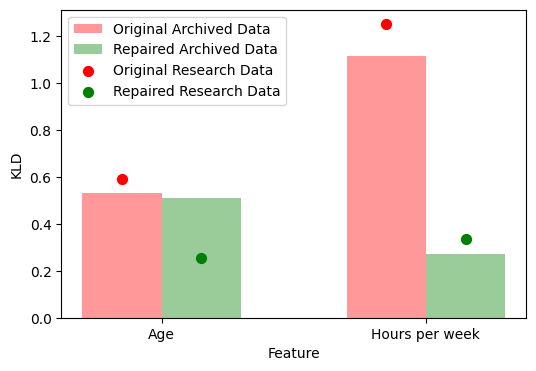

In [151]:


fig, ax = plt.subplots(1,1,figsize=(6, 4))

bar_width = 0.3
original_color = 'red'
repaired_color = 'green'

kld_x_A_mean = np.mean(kld_x_A, axis=1)
kld_x_tilde_A_mean = np.mean(kld_x_tilde_A, axis=1)
kld_x_R_mean = np.mean(kld_x_R, axis=1)
kld_x_tilde_R_mean = np.mean(kld_x_tilde_R, axis=1)

pos = np.arange(len(kld_x_A_mean))
original_bars = ax.bar(x=pos - bar_width/2, height=kld_x_A_mean, width=bar_width, alpha=0.4, color=original_color)
repaired_bars = ax.bar(x=pos + bar_width/2, height=kld_x_tilde_A_mean, width=bar_width, alpha=0.4, color=repaired_color)
original_scatter = ax.scatter(x=pos - bar_width/2, y=kld_x_R_mean, color=original_color, marker='o', s=50)
repaired_scatter = ax.scatter(x=pos + bar_width/2, y=kld_x_tilde_R_mean, color=repaired_color, marker='o', s=50)

x_labels = [feat.replace('-', ' ').capitalize() for feat in feats if feat not in plot_ignored_features]
ax.set_xticks(pos)
ax.set_xticklabels(x_labels)
# ax.set_title(f"Adult Dataset ({n_R:,} : {len(tilde_x_A):,}, Research : Archive)\n S: {s.title()}, U: {u.replace('_', ' ').title()}\n X: {', '.join([x.replace('-', ' ').title() for x in x if x])}, Y: {y.replace(' ', ' ').title()}", fontsize=12)

handles = [original_bars, repaired_bars, original_scatter, repaired_scatter]
labels = ['Original Archived Data', 'Repaired Archived Data', 'Original Research Data', 'Repaired Research Data']

ax.legend(handles, labels)
ax.set_ylabel("KLD")
ax.set_xlabel("Feature")

# plt.suptitle("U-Mean KLD between P(X|S=1,U) and P(X|S=0,U)", fontsize=16)
# plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [165]:
dataset_tests = [
    {'data_loader': load_compas_dataset,
    'dataset_name':'COMPAS',
    's':'race',
    'u':'c_charge_degree',
    'x':['age','priors_count','decile_score'],
    'y':'is_recid',
    'n_R': 5000,
    'n_A':0,
    'n_q': 250,
    'continuous_features' : ['age'],
    'plot_ignored_features': [],
    'results': {'kld_x_R': [], 'kld_x_tilde_R': [], 'kld_x_A': [], 'kld_x_tilde_A': [], 'runtime':[]}
    },
    {'data_loader': load_compas_dataset,
    'dataset_name':'COMPAS',
    's':'sex',
    'u':'c_charge_degree',
    'x':['age','priors_count','decile_score'],
    'y':'is_recid',
    'n_R': 5000,
    'n_A':0,
    'n_q': 250,
    'continuous_features' : ['age'],
    'plot_ignored_features': [],
    'results': {'kld_x_R': [], 'kld_x_tilde_R': [], 'kld_x_A': [], 'kld_x_tilde_A': [],'runtime':[]}
    },
    {'data_loader': load_adult_dataset,
    'dataset_name':'Adult',
    's':'sex',
    'u':'college_educated',
    'x':['age','education-num','hours-per-week'],
    'y':'Income Binary',
    'n_R': 10000,
    'n_A':0,
    'n_q': 250,
    'continuous_features' : ['age','hours-per-week'],
    'plot_ignored_features': ['education-num'],
    'results': {'kld_x_R': [], 'kld_x_tilde_R': [], 'kld_x_A': [], 'kld_x_tilde_A': [],'runtime':[]}
    },
    {'data_loader': load_adult_dataset,
    'dataset_name':'Adult',
    's':'race',
    'u':'college_educated',
    'x':['age','education-num','hours-per-week'],
    'y':'Income Binary',
    'n_R': 10000,
    'n_A':0,
    'n_q': 250,
    'continuous_features' : ['age','hours-per-week'],
    'plot_ignored_features': ['education-num'],
    'results': {'kld_x_R': [], 'kld_x_tilde_R': [], 'kld_x_A': [], 'kld_x_tilde_A': [],'runtime':[]}
    },
]

In [11]:
trials = 50

with tqdm(total=len(dataset_tests) * trials, desc="Progress") as pbar:
    for t in dataset_tests:
        for i in range(trials):
            data = t['data_loader'](t['s'], t['u'], t['x'], t['y'])
            data_R, data_A = data.split([t['n_R']], shuffle=True)
            t['n_A'] = len(data_A.convert_to_dataframe()[0])
            if len(data_A.convert_to_dataframe()[0]) == 0:
                print("There are no samples in the archived dataset. Skipping this trial.")
            d = DistributionalRepair(t['s'], t['u'], t['x'], t['y'], t['continuous_features'], t['n_q'])
            runtimes={}
            t0 = time.perf_counter()
            d.fit(data_R)
            t1 = time.perf_counter()
            dataset_R_repaired = d.transform(data_R)
            t2 = time.perf_counter()
            dataset_A_repaired = d.transform(data_A)
            t3 = time.perf_counter()
            runtimes['fit'] = t1 - t0
            runtimes['transform_R'] = t2 - t1
            runtimes['transform_A'] = t3 - t2
            t['results']['runtime'].append(runtimes)
            # dataset_R_repaired, dataset_A_repaired = d.fit_transform(data_R, data_A)
            tilde_x_R = dataset_R_repaired.convert_to_dataframe()[0][t['x']]
            tilde_x_A = dataset_A_repaired.convert_to_dataframe()[0][t['x']]
            feats = [f for f in t['x'] if f not in t['plot_ignored_features']]
            kld_x_R = np.zeros(shape=(len(feats), 2))
            kld_x_tilde_R = np.zeros(shape=(len(feats), 2))
            kld_x_A = np.zeros(shape=(len(feats), 2))
            kld_x_tilde_A = np.zeros(shape=(len(feats), 2))
            pos = np.arange(len(feats))
            for i, feat in enumerate(feats):
                kld_x_R[i, 0] = eval_kld(d.x_R[feat], d.s_R, d.u_R, order=[0, 1])
                kld_x_R[i, 1] = eval_kld(d.x_R[feat], d.s_R, d.u_R, order=[1, 0])
                kld_x_tilde_R[i, 0] = eval_kld(tilde_x_R[feat], d.s_R, d.u_R, order=[0, 1])
                kld_x_tilde_R[i, 1] = eval_kld(tilde_x_R[feat], d.s_R, d.u_R, order=[1, 0])
                kld_x_A[i, 0] = eval_kld(data_A.convert_to_dataframe()[0][t['x']][feat], data_A.convert_to_dataframe()[0][t['s']], data_A.convert_to_dataframe()[0][t['u']], order=[0, 1])
                kld_x_A[i, 1] = eval_kld(data_A.convert_to_dataframe()[0][t['x']][feat], data_A.convert_to_dataframe()[0][t['s']], data_A.convert_to_dataframe()[0][t['u']], order=[1, 0])
                kld_x_tilde_A[i, 0] = eval_kld(tilde_x_A[feat], data_A.convert_to_dataframe()[0][t['s']], data_A.convert_to_dataframe()[0][t['u']], order=[0, 1])
                kld_x_tilde_A[i, 1] = eval_kld(tilde_x_A[feat], data_A.convert_to_dataframe()[0][t['s']], data_A.convert_to_dataframe()[0][t['u']], order=[1, 0])
            t['results']['kld_x_R'].append(kld_x_R)
            t['results']['kld_x_tilde_R'].append(kld_x_tilde_R)
            t['results']['kld_x_A'].append(kld_x_A)
            t['results']['kld_x_tilde_A'].append(kld_x_tilde_A)
            pbar.update(1)  # Update the progress bar after each trial

Progress: 100%|██████████| 200/200 [44:48<00:00, 13.44s/it]


In [166]:
# import pickle
# with open('dataset_tests.pkl', 'wb') as f:
#     pickle.dump(dataset_tests, f)

# # load dataset_tests
import pickle
with open('dataset_tests.pkl', 'rb') as f:
    dataset_tests = pickle.load(f)

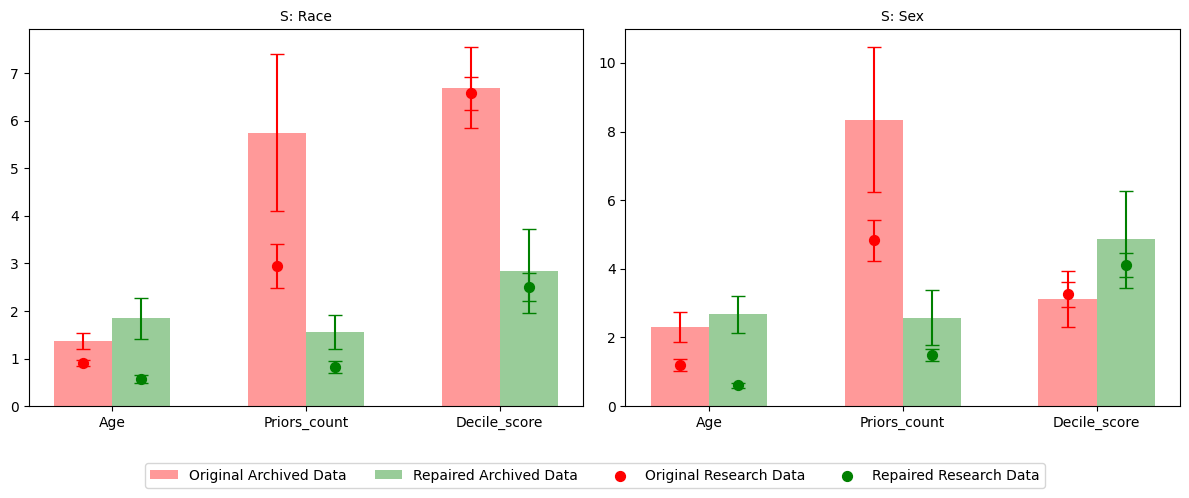

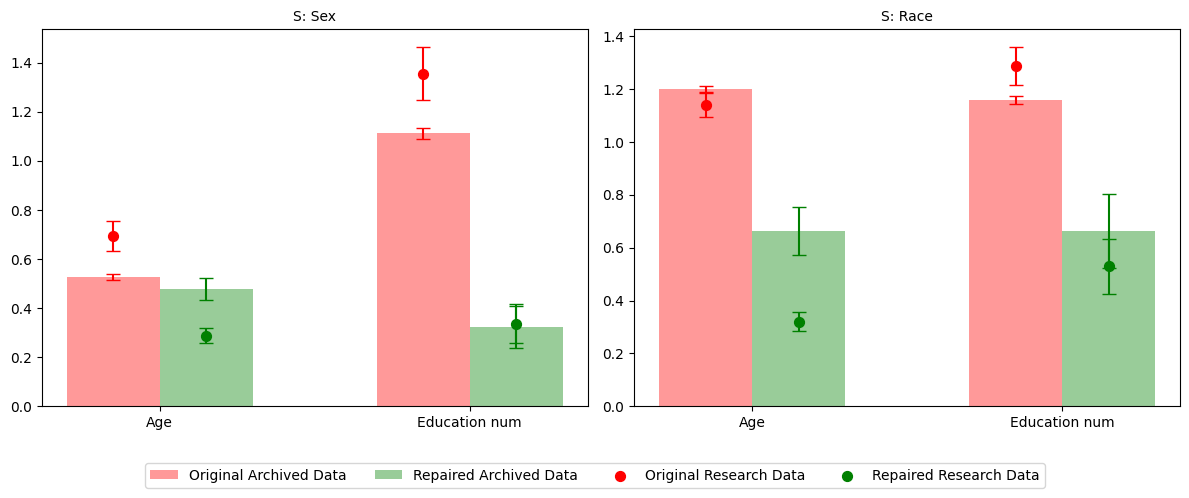

In [182]:
# First plot
fig1, axs1 = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axs1 = axs1.flatten()
handles1 = []

# Second plot
fig2, axs2 = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axs2 = axs2.flatten()
handles2 = []

for i, t in enumerate(dataset_tests):
    if i < 2:
        ax = axs1[i]
        handles = handles1
    else:
        ax = axs2[i-2]
        handles = handles2
    
    bar_width = 0.3
    original_color = 'red'
    repaired_color = 'green'
    
    kld_x_A_mean = np.mean(t['results']['kld_x_A'], axis=0)[:, 0]
    kld_x_tilde_A_mean = np.mean(t['results']['kld_x_tilde_A'], axis=0)[:, 0]
    kld_x_R_mean = np.mean(t['results']['kld_x_R'], axis=0)[:, 0]
    kld_x_tilde_R_mean = np.mean(t['results']['kld_x_tilde_R'], axis=0)[:, 0]
    
    kld_x_A_std = np.std(t['results']['kld_x_A'], axis=0)[:, 0]
    kld_x_tilde_A_std = np.std(t['results']['kld_x_tilde_A'], axis=0)[:, 0]
    kld_x_R_std = np.std(t['results']['kld_x_R'], axis=0)[:, 0]
    kld_x_tilde_R_std = np.std(t['results']['kld_x_tilde_R'], axis=0)[:, 0]
    
    pos = np.arange(len(kld_x_A_mean))
    original_bars = ax.bar(x=pos - bar_width/2, height=kld_x_A_mean, width=bar_width, alpha=0.4, color=original_color)
    repaired_bars = ax.bar(x=pos + bar_width/2, height=kld_x_tilde_A_mean, width=bar_width, alpha=0.4, color=repaired_color)
    
    original_scatter = ax.scatter(x=pos - bar_width/2, y=kld_x_R_mean, color=original_color, marker='o', s=50)
    repaired_scatter = ax.scatter(x=pos + bar_width/2, y=kld_x_tilde_R_mean, color=repaired_color, marker='o', s=50)
    
    ax.errorbar(x=pos - bar_width/2, y=kld_x_R_mean, yerr=kld_x_R_std, fmt='none', ecolor=original_color, capsize=5)
    ax.errorbar(x=pos + bar_width/2, y=kld_x_tilde_R_mean, yerr=kld_x_tilde_R_std, fmt='none', ecolor=repaired_color, capsize=5)
    
    ax.errorbar(x=pos - bar_width/2, y=kld_x_A_mean, yerr=kld_x_A_std, fmt='none', ecolor=original_color, capsize=5)
    ax.errorbar(x=pos + bar_width/2, y=kld_x_tilde_A_mean, yerr=kld_x_tilde_A_std, fmt='none', ecolor=repaired_color, capsize=5)
    
    x_labels = [x.replace('-', ' ').capitalize() for x in t['x']]
    ax.set_xticks(pos)
    ax.set_xticklabels(x_labels[:len(pos)])
    ax.set_title(f"S: {t['s'].title()}", fontsize=10)
    
    #y-axis label
    if i % 2 == 0:
        ax.set_ylabel("U-Mean KLD")

    if i % 2 == 0:
        handles.extend([original_bars, repaired_bars, original_scatter, repaired_scatter])
        
labels = ['Original Archived Data', 'Repaired Archived Data', 'Original Research Data', 'Repaired Research Data']

fig1.legend(handles1, labels, loc='lower center', bbox_to_anchor=(0.5, 0), ncol=4)
fig1.tight_layout(rect=[0, 0.1, 1, 1])

fig2.legend(handles2, labels, loc='lower center', bbox_to_anchor=(0.5, 0), ncol=4)
fig2.tight_layout(rect=[0, 0.1, 1, 1])

In [158]:
n_R_tests = []

max_n_R = 15000



base_config = {
    'data_loader': load_adult_dataset,
    'dataset_name': 'Adult',
    's': 'sex',
    'u': 'college_educated',
    'x': ['age', 'education-num', 'hours-per-week'],
    'y': 'Income Binary',
    'n_A': 30000,
    'n_q': 250,
    'continuous_features': ['age', 'hours-per-week'],
    'plot_ignored_features': ['education-num'],
}

for n_R in range(1000, max_n_R, 1000):
    config = base_config.copy()
    config['n_R'] = n_R
    config['results'] = {'kld_x_R': [], 'kld_x_tilde_R': [], 'kld_x_A': [], 'kld_x_tilde_A': [], 'runtime': []}
    n_R_tests.append(config)

In [159]:
trials = 30

with tqdm(total=len(n_R_tests) * trials, desc="Progress") as pbar:
    for i in range(trials):
        for t in n_R_tests:
            data = t['data_loader'](t['s'], t['u'], t['x'], t['y'])
            data_R, data_A_temp = data.split([t['n_R']], shuffle=True)
            data_A, _ = data_A_temp.split([t['n_A']], shuffle=True)
            t['n_A'] = len(data_A.convert_to_dataframe()[0])
            if len(data_A.convert_to_dataframe()[0]) == 0:
                print("There are no samples in the archived dataset. Skipping this trial.")
            d = DistributionalRepair(t['s'], t['u'], t['x'], t['y'], t['continuous_features'], t['n_q'])
            runtimes={}
            t0 = time.perf_counter()
            d.fit(data_R)
            t1 = time.perf_counter()
            dataset_R_repaired = d.transform(data_R)
            t2 = time.perf_counter()
            dataset_A_repaired = d.transform(data_A)
            t3 = time.perf_counter()
            runtimes['fit'] = t1 - t0
            runtimes['transform_R'] = t2 - t1
            runtimes['transform_A'] = t3 - t2
            t['results']['runtime'].append(runtimes)
            # dataset_R_repaired, dataset_A_repaired = d.fit_transform(data_R, data_A)
            tilde_x_R = dataset_R_repaired.convert_to_dataframe()[0][t['x']]
            tilde_x_A = dataset_A_repaired.convert_to_dataframe()[0][t['x']]
            feats = [f for f in t['x'] if f not in t['plot_ignored_features']]
            kld_x_R = np.zeros(shape=(len(feats), 2))
            kld_x_tilde_R = np.zeros(shape=(len(feats), 2))
            kld_x_A = np.zeros(shape=(len(feats), 2))
            kld_x_tilde_A = np.zeros(shape=(len(feats), 2))
            pos = np.arange(len(feats))
            for i, feat in enumerate(feats):
                kld_x_R[i, 0] = eval_kld(d.x_R[feat], d.s_R, d.u_R, order=[0, 1])
                kld_x_R[i, 1] = eval_kld(d.x_R[feat], d.s_R, d.u_R, order=[1, 0])
                kld_x_tilde_R[i, 0] = eval_kld(tilde_x_R[feat], d.s_R, d.u_R, order=[0, 1])
                kld_x_tilde_R[i, 1] = eval_kld(tilde_x_R[feat], d.s_R, d.u_R, order=[1, 0])
                kld_x_A[i, 0] = eval_kld(data_A.convert_to_dataframe()[0][t['x']][feat], data_A.convert_to_dataframe()[0][t['s']], data_A.convert_to_dataframe()[0][t['u']], order=[0, 1])
                kld_x_A[i, 1] = eval_kld(data_A.convert_to_dataframe()[0][t['x']][feat], data_A.convert_to_dataframe()[0][t['s']], data_A.convert_to_dataframe()[0][t['u']], order=[1, 0])
                kld_x_tilde_A[i, 0] = eval_kld(tilde_x_A[feat], data_A.convert_to_dataframe()[0][t['s']], data_A.convert_to_dataframe()[0][t['u']], order=[0, 1])
                kld_x_tilde_A[i, 1] = eval_kld(tilde_x_A[feat], data_A.convert_to_dataframe()[0][t['s']], data_A.convert_to_dataframe()[0][t['u']], order=[1, 0])
            t['results']['kld_x_R'].append(kld_x_R)
            t['results']['kld_x_tilde_R'].append(kld_x_tilde_R)
            t['results']['kld_x_A'].append(kld_x_A)
            t['results']['kld_x_tilde_A'].append(kld_x_tilde_A)
            pbar.update(1)  # Update the progress bar after each trial

Progress:   0%|          | 0/420 [00:00<?, ?it/s]

Progress: 100%|██████████| 420/420 [2:12:28<00:00, 18.93s/it]  


In [160]:
import pickle
# save n_R_tests
with open('n_R_tests.pkl', 'wb') as f:
    pickle.dump(n_R_tests, f)

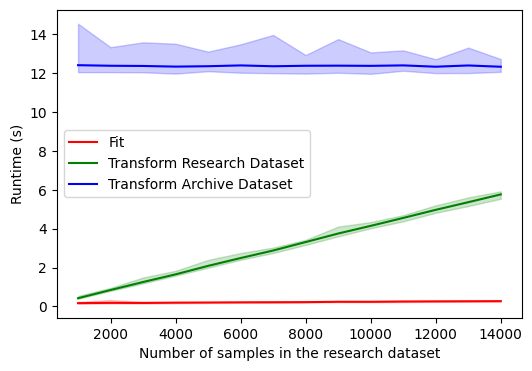

In [161]:
runtimes_fit_avg = []
runtimes_fit_min = []
runtimes_fit_max = []
runtimes_transform_R_avg = []
runtimes_transform_R_min = []
runtimes_transform_R_max = []
runtimes_transform_A_avg = []
runtimes_transform_A_min = []
runtimes_transform_A_max = []

for t in n_R_tests:
    fit_values = [r['fit'] for r in t['results']['runtime']]
    transform_R_values = [r['transform_R'] for r in t['results']['runtime']]
    transform_A_values = [r['transform_A'] for r in t['results']['runtime']]
    
    runtimes_fit_avg.append(np.mean(fit_values))
    runtimes_fit_min.append(np.min(fit_values))
    runtimes_fit_max.append(np.max(fit_values))
    
    runtimes_transform_R_avg.append(np.mean(transform_R_values))
    runtimes_transform_R_min.append(np.min(transform_R_values))
    runtimes_transform_R_max.append(np.max(transform_R_values))
    
    runtimes_transform_A_avg.append(np.mean(transform_A_values))
    runtimes_transform_A_min.append(np.min(transform_A_values))
    runtimes_transform_A_max.append(np.max(transform_A_values))

# Plot runtimes across values of n_R
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

n_R_values = [t['n_R'] for t in n_R_tests]

ax.plot(n_R_values, runtimes_fit_avg, label='Fit', color='red')
ax.fill_between(n_R_values, runtimes_fit_min, runtimes_fit_max, color='red', alpha=0.2)

ax.plot(n_R_values, runtimes_transform_R_avg, label='Transform Research Dataset', color='green')
ax.fill_between(n_R_values, runtimes_transform_R_min, runtimes_transform_R_max, color='green', alpha=0.2)

ax.plot(n_R_values, runtimes_transform_A_avg, label='Transform Archive Dataset', color='blue')
ax.fill_between(n_R_values, runtimes_transform_A_min, runtimes_transform_A_max, color='blue', alpha=0.2)

ax.set_xlabel('Number of samples in the research dataset')
ax.set_ylabel('Runtime (s)')
# ax.set_title('Runtime of Fit and Transform Operations')
ax.legend()

plt.show()

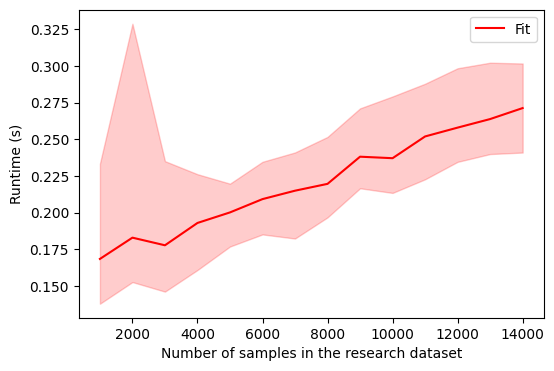

In [163]:
runtimes_fit_avg = []
runtimes_fit_min = []
runtimes_fit_max = []

for t in n_R_tests:
    fit_values = [r['fit'] for r in t['results']['runtime']]

    runtimes_fit_avg.append(np.mean(fit_values))
    runtimes_fit_min.append(np.min(fit_values))
    runtimes_fit_max.append(np.max(fit_values))


# Plot runtimes across values of n_R
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

n_R_values = [t['n_R'] for t in n_R_tests]

ax.plot(n_R_values, runtimes_fit_avg, label='Fit', color='red')
ax.fill_between(n_R_values, runtimes_fit_min, runtimes_fit_max, color='red', alpha=0.2)


ax.set_xlabel('Number of samples in the research dataset')
ax.set_ylabel('Runtime (s)')
# ax.set_title('Runtime of Fit and Transform Operations')
ax.legend()

plt.show()

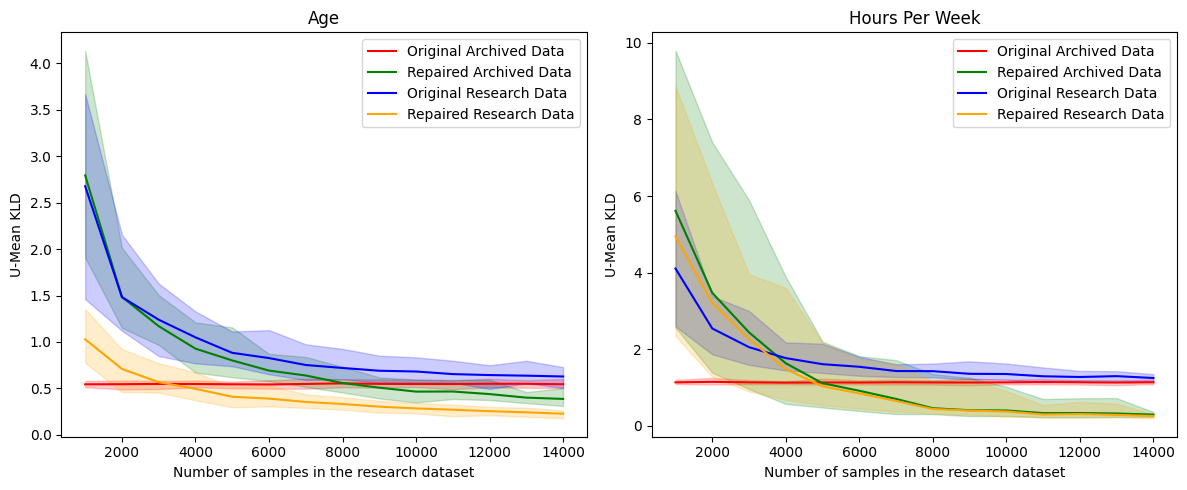

In [162]:
fig, axs = plt.subplots(1,len(feats), figsize=(12, 5))
for i, f in enumerate(feats):
    kld_x_A_mean_scores = []
    kld_x_tilde_A_mean_scores = []
    kld_x_R_mean_scores = []
    kld_x_tilde_R_mean_scores = []
    kld_x_A_min_scores = []
    kld_x_tilde_A_min_scores = []
    kld_x_R_min_scores = []
    kld_x_tilde_R_min_scores = []
    kld_x_A_max_scores = []
    kld_x_tilde_A_max_scores = []
    kld_x_R_max_scores = []
    kld_x_tilde_R_max_scores = []
    for t in n_R_tests:
        kld_x_A_mean_scores.append(np.mean(t['results']['kld_x_A'], axis=0)[feats.index(f), 0])
        kld_x_tilde_A_mean_scores.append(np.mean(t['results']['kld_x_tilde_A'], axis=0)[feats.index(f), 0])
        kld_x_R_mean_scores.append(np.mean(t['results']['kld_x_R'], axis=0)[feats.index(f), 0])
        kld_x_tilde_R_mean_scores.append(np.mean(t['results']['kld_x_tilde_R'], axis=0)[feats.index(f), 0])
        kld_x_A_min_scores.append(np.min(t['results']['kld_x_A'], axis=0)[feats.index(f), 0])
        kld_x_tilde_A_min_scores.append(np.min(t['results']['kld_x_tilde_A'], axis=0)[feats.index(f), 0])
        kld_x_R_min_scores.append(np.min(t['results']['kld_x_R'], axis=0)[feats.index(f), 0])
        kld_x_tilde_R_min_scores.append(np.min(t['results']['kld_x_tilde_R'], axis=0)[feats.index(f), 0])
        kld_x_A_max_scores.append(np.max(t['results']['kld_x_A'], axis=0)[feats.index(f), 0])
        kld_x_tilde_A_max_scores.append(np.max(t['results']['kld_x_tilde_A'], axis=0)[feats.index(f), 0])
        kld_x_R_max_scores.append(np.max(t['results']['kld_x_R'], axis=0)[feats.index(f), 0])
        kld_x_tilde_R_max_scores.append(np.max(t['results']['kld_x_tilde_R'], axis=0)[feats.index(f), 0])
    n_R_values = [t['n_R'] for t in n_R_tests]
    axs[i].plot(n_R_values, kld_x_A_mean_scores, label='Original Archived Data', color='red')
    axs[i].fill_between(n_R_values, kld_x_A_min_scores, kld_x_A_max_scores, color='red', alpha=0.2)
    axs[i].plot(n_R_values, kld_x_tilde_A_mean_scores, label='Repaired Archived Data', color='green')
    axs[i].fill_between(n_R_values, kld_x_tilde_A_min_scores, kld_x_tilde_A_max_scores, color='green', alpha=0.2)
    axs[i].plot(n_R_values, kld_x_R_mean_scores, label='Original Research Data', color='blue')
    axs[i].fill_between(n_R_values, kld_x_R_min_scores, kld_x_R_max_scores, color='blue', alpha=0.2)
    axs[i].plot(n_R_values, kld_x_tilde_R_mean_scores, label='Repaired Research Data', color='orange')
    axs[i].fill_between(n_R_values, kld_x_tilde_R_min_scores, kld_x_tilde_R_max_scores, color='orange', alpha=0.2)
    axs[i].set_xlabel('Number of samples in the research dataset')
    axs[i].set_ylabel('U-Mean KLD')
    axs[i].set_title(f'{f.replace("-", " ").title()}')
    axs[i].legend()
plt.tight_layout()
plt.show()

In [53]:
n_q_tests = []

base_config = {
    'data_loader': load_adult_dataset,
    'dataset_name': 'Adult',
    's': 'sex',
    'u': 'college_educated',
    'x': ['age', 'education-num', 'hours-per-week'],
    'y': 'Income Binary',
    'n_R': 10000,
    'n_q': 0,
    'continuous_features': ['age', 'hours-per-week'],
    'plot_ignored_features': ['education-num'],
}

for n_q in range(50, 1000, 50):
    config = base_config.copy()
    config['n_q'] = n_q
    config['results'] = {'kld_x_R': [], 'kld_x_tilde_R': [], 'kld_x_A': [], 'kld_x_tilde_A': [], 'runtime': []}
    n_q_tests.append(config)

print(len(n_q_tests))

38


In [54]:
trials = 20

with tqdm(total=len(n_q_tests) * trials, desc="Progress") as pbar:
    for i in range(trials):
        for t in n_q_tests:
            data = t['data_loader'](t['s'], t['u'], t['x'], t['y'])
            data_R, data_A = data.split([t['n_R']], shuffle=True)
            t['n_A'] = len(data_A.convert_to_dataframe()[0])
            if len(data_A.convert_to_dataframe()[0]) == 0:
                print("There are no samples in the archived dataset. Skipping this trial.")
            d = DistributionalRepair(t['s'], t['u'], t['x'], t['y'], t['continuous_features'], t['n_q'])
            runtimes={}
            t0 = time.perf_counter()
            d.fit(data_R)
            t1 = time.perf_counter()
            dataset_R_repaired = d.transform(data_R)
            t2 = time.perf_counter()
            dataset_A_repaired = d.transform(data_A)
            t3 = time.perf_counter()
            runtimes['fit'] = t1 - t0
            runtimes['transform_R'] = t2 - t1
            runtimes['transform_A'] = t3 - t2
            t['results']['runtime'].append(runtimes)
            # dataset_R_repaired, dataset_A_repaired = d.fit_transform(data_R, data_A)
            tilde_x_R = dataset_R_repaired.convert_to_dataframe()[0][t['x']]
            tilde_x_A = dataset_A_repaired.convert_to_dataframe()[0][t['x']]
            feats = [f for f in t['x'] if f not in t['plot_ignored_features']]
            kld_x_R = np.zeros(shape=(len(feats), 2))
            kld_x_tilde_R = np.zeros(shape=(len(feats), 2))
            kld_x_A = np.zeros(shape=(len(feats), 2))
            kld_x_tilde_A = np.zeros(shape=(len(feats), 2))
            pos = np.arange(len(feats))
            for i, feat in enumerate(feats):
                kld_x_R[i, 0] = eval_kld(d.x_R[feat], d.s_R, d.u_R, order=[0, 1])
                kld_x_R[i, 1] = eval_kld(d.x_R[feat], d.s_R, d.u_R, order=[1, 0])
                kld_x_tilde_R[i, 0] = eval_kld(tilde_x_R[feat], d.s_R, d.u_R, order=[0, 1])
                kld_x_tilde_R[i, 1] = eval_kld(tilde_x_R[feat], d.s_R, d.u_R, order=[1, 0])
                kld_x_A[i, 0] = eval_kld(data_A.convert_to_dataframe()[0][t['x']][feat], data_A.convert_to_dataframe()[0][t['s']], data_A.convert_to_dataframe()[0][t['u']], order=[0, 1])
                kld_x_A[i, 1] = eval_kld(data_A.convert_to_dataframe()[0][t['x']][feat], data_A.convert_to_dataframe()[0][t['s']], data_A.convert_to_dataframe()[0][t['u']], order=[1, 0])
                kld_x_tilde_A[i, 0] = eval_kld(tilde_x_A[feat], data_A.convert_to_dataframe()[0][t['s']], data_A.convert_to_dataframe()[0][t['u']], order=[0, 1])
                kld_x_tilde_A[i, 1] = eval_kld(tilde_x_A[feat], data_A.convert_to_dataframe()[0][t['s']], data_A.convert_to_dataframe()[0][t['u']], order=[1, 0])
            t['results']['kld_x_R'].append(kld_x_R)
            t['results']['kld_x_tilde_R'].append(kld_x_tilde_R)
            t['results']['kld_x_A'].append(kld_x_A)
            t['results']['kld_x_tilde_A'].append(kld_x_tilde_A)
            pbar.update(1)  # Update the progress bar after each trial

Progress: 100%|██████████| 760/760 [4:57:15<00:00, 23.47s/it]  


In [77]:
# import pickle
# # save n_q_tests
# with open('n_q_tests.pkl', 'wb') as f:
#     pickle.dump(n_q_tests, f)

#load n_q_tests
import pickle
with open('n_q_tests.pkl', 'rb') as f:
    n_q_tests = pickle.load(f)

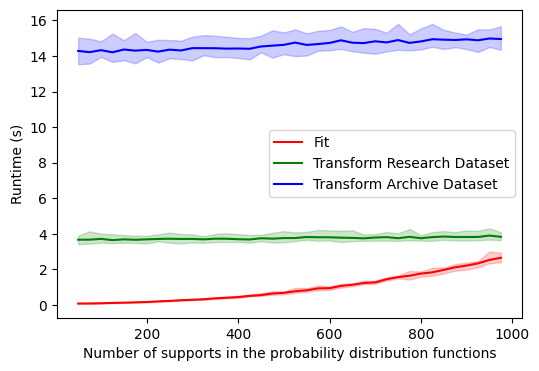

In [78]:
runtimes_fit_avg = []
runtimes_fit_min = []
runtimes_fit_max = []
runtimes_transform_R_avg = []
runtimes_transform_R_min = []
runtimes_transform_R_max = []
runtimes_transform_A_avg = []
runtimes_transform_A_min = []
runtimes_transform_A_max = []

for t in n_q_tests:
    fit_values = [r['fit'] for r in t['results']['runtime']]
    transform_R_values = [r['transform_R'] for r in t['results']['runtime']]
    transform_A_values = [r['transform_A'] for r in t['results']['runtime']]
    
    runtimes_fit_avg.append(np.mean(fit_values))
    runtimes_fit_min.append(np.min(fit_values))
    runtimes_fit_max.append(np.max(fit_values))
    
    runtimes_transform_R_avg.append(np.mean(transform_R_values))
    runtimes_transform_R_min.append(np.min(transform_R_values))
    runtimes_transform_R_max.append(np.max(transform_R_values))
    
    runtimes_transform_A_avg.append(np.mean(transform_A_values))
    runtimes_transform_A_min.append(np.min(transform_A_values))
    runtimes_transform_A_max.append(np.max(transform_A_values))

# Plot runtimes across values of n_R
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

n_q_values = [t['n_q'] for t in n_q_tests]

ax.plot(n_q_values, runtimes_fit_avg, label='Fit', color='red')
ax.fill_between(n_q_values, runtimes_fit_min, runtimes_fit_max, color='red', alpha=0.2)

ax.plot(n_q_values, runtimes_transform_R_avg, label='Transform Research Dataset', color='green')
ax.fill_between(n_q_values, runtimes_transform_R_min, runtimes_transform_R_max, color='green', alpha=0.2)

ax.plot(n_q_values, runtimes_transform_A_avg, label='Transform Archive Dataset', color='blue')
ax.fill_between(n_q_values, runtimes_transform_A_min, runtimes_transform_A_max, color='blue', alpha=0.2)

ax.set_xlabel('Number of supports in the probability distribution functions')
ax.set_ylabel('Runtime (s)')
# ax.set_title('Runtime of Fit and Transform Operations')
ax.legend()

plt.show()

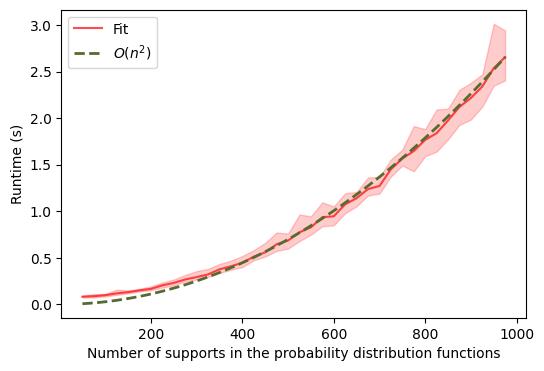

In [138]:
import numpy as np
import matplotlib.pyplot as plt

runtimes_fit_avg = []
runtimes_fit_min = []
runtimes_fit_max = []
for t in n_q_tests:
    fit_values = [r['fit'] for r in t['results']['runtime']]
    runtimes_fit_avg.append(np.mean(fit_values))
    runtimes_fit_min.append(np.min(fit_values))
    runtimes_fit_max.append(np.max(fit_values))

# Plot runtimes across values of n_R
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
n_q_values = [t['n_q'] for t in n_q_tests]
ax.plot(n_q_values, runtimes_fit_avg, label='Fit', color='red',alpha=0.7)
ax.fill_between(n_q_values, runtimes_fit_min, runtimes_fit_max, color='red', alpha=0.2)

# Generate points for the comparison curves
n_values = np.linspace(min(n_q_values), max(n_q_values), 100)

# # Overlay 2^n curve
# two_power_n = np.power(2, n_values)
# ax.plot(n_values, two_power_n / np.max(two_power_n) * np.max(runtimes_fit_avg), label='2^n', linestyle='--', color='blue')

# Overlay n^2 curve
n_square = np.power(n_values, 2)
ax.plot(n_values, n_square / np.max(n_square) * np.max(runtimes_fit_avg), label='$O(n^2)$', linestyle='--', color='darkolivegreen', linewidth=2, alpha=1)

# # Overlay ln(n) curve
# ln_n = np.log(n_values)
# ax.plot(n_values, ln_n / np.max(ln_n) * np.max(runtimes_fit_avg), label='ln(n)', linestyle='-.', color='orange')

ax.set_xlabel('Number of supports in the probability distribution functions')
ax.set_ylabel('Runtime (s)')
# ax.set_title('Runtime Comparison with Complexity Curves')
ax.legend(loc='upper left')

# plt.tight_layout()
plt.show()

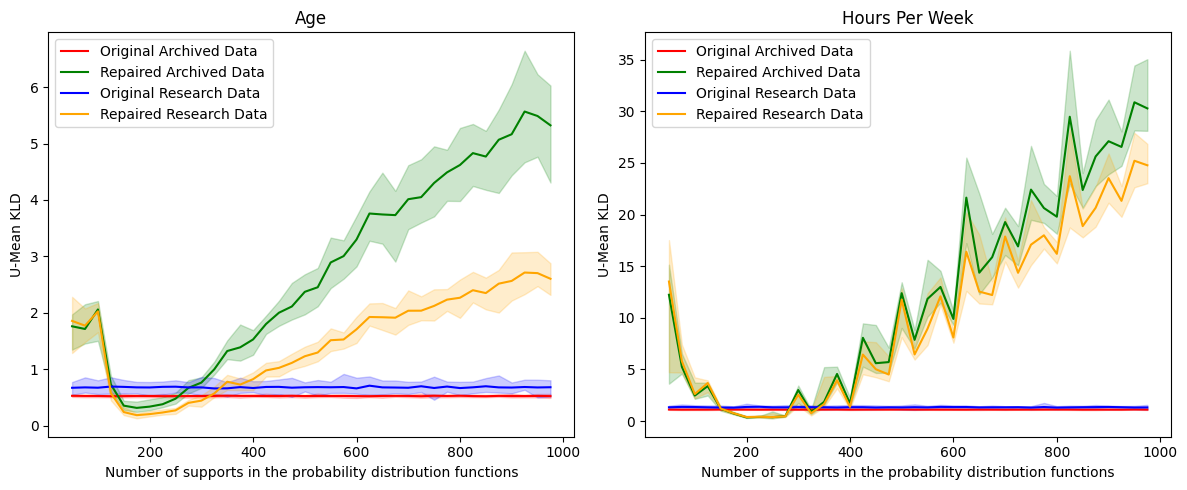

In [90]:
fig, axs = plt.subplots(1, len(feats), figsize=(12, 5))
for i, f in enumerate(feats):
    kld_x_A_mean_scores = []
    kld_x_tilde_A_mean_scores = []
    kld_x_R_mean_scores = []
    kld_x_tilde_R_mean_scores = []
    kld_x_A_min_scores = []
    kld_x_tilde_A_min_scores = []
    kld_x_R_min_scores = []
    kld_x_tilde_R_min_scores = []
    kld_x_A_max_scores = []
    kld_x_tilde_A_max_scores = []
    kld_x_R_max_scores = []
    kld_x_tilde_R_max_scores = []
    for t in n_q_tests:
        kld_x_A_mean_scores.append(np.mean(t['results']['kld_x_A'], axis=0)[feats.index(f), 0])
        kld_x_tilde_A_mean_scores.append(np.mean(t['results']['kld_x_tilde_A'], axis=0)[feats.index(f), 0])
        kld_x_R_mean_scores.append(np.mean(t['results']['kld_x_R'], axis=0)[feats.index(f), 0])
        kld_x_tilde_R_mean_scores.append(np.mean(t['results']['kld_x_tilde_R'], axis=0)[feats.index(f), 0])
        kld_x_A_min_scores.append(np.min(t['results']['kld_x_A'], axis=0)[feats.index(f), 0])
        kld_x_tilde_A_min_scores.append(np.min(t['results']['kld_x_tilde_A'], axis=0)[feats.index(f), 0])
        kld_x_R_min_scores.append(np.min(t['results']['kld_x_R'], axis=0)[feats.index(f), 0])
        kld_x_tilde_R_min_scores.append(np.min(t['results']['kld_x_tilde_R'], axis=0)[feats.index(f), 0])
        kld_x_A_max_scores.append(np.max(t['results']['kld_x_A'], axis=0)[feats.index(f), 0])
        kld_x_tilde_A_max_scores.append(np.max(t['results']['kld_x_tilde_A'], axis=0)[feats.index(f), 0])
        kld_x_R_max_scores.append(np.max(t['results']['kld_x_R'], axis=0)[feats.index(f), 0])
        kld_x_tilde_R_max_scores.append(np.max(t['results']['kld_x_tilde_R'], axis=0)[feats.index(f), 0])
    n_q_values = [t['n_q'] for t in n_q_tests]
    axs[i].plot(n_q_values, kld_x_A_mean_scores, label='Original Archived Data', color='red')
    axs[i].fill_between(n_q_values, kld_x_A_min_scores, kld_x_A_max_scores, color='red', alpha=0.2)
    axs[i].plot(n_q_values, kld_x_tilde_A_mean_scores, label='Repaired Archived Data', color='green')
    axs[i].fill_between(n_q_values, kld_x_tilde_A_min_scores, kld_x_tilde_A_max_scores, color='green', alpha=0.2)
    axs[i].plot(n_q_values, kld_x_R_mean_scores, label='Original Research Data', color='blue')
    axs[i].fill_between(n_q_values, kld_x_R_min_scores, kld_x_R_max_scores, color='blue', alpha=0.2)
    axs[i].plot(n_q_values, kld_x_tilde_R_mean_scores, label='Repaired Research Data', color='orange')
    axs[i].fill_between(n_q_values, kld_x_tilde_R_min_scores, kld_x_tilde_R_max_scores, color='orange', alpha=0.2)
    axs[i].set_xlabel('Number of supports in the probability distribution functions')
    axs[i].set_ylabel('U-Mean KLD')
    axs[i].set_title(f'{f.replace("-", " ").title()}')
    #upper left
    axs[i].legend(loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
s1 = 'sex'
s2 = 'race'
u = 'college_educated'
x = ['age','education-num','hours-per-week']
y = 'Income Binary'
plot_ignored_features = ['education-num']

n_R = 10000 # number of points in the research dataset
n_q = 250 # number of supports under the estimated probability distribution functions

continuous_features = ['age','hours-per-week']

plot_ignored_features = []


In [ ]:
dataR, dataA = load_adult_dataset(s1,u,x,y,additional_cols=[s2]).split([n_R], shuffle=False)

d_s1 = DistributionalRepair(s1,u,x,y,continuous_features,n_q)
data_R_s1_repaired, data_A_s1_repaired = d_s1.fit_transform(dataR, dataA)
d_s1_s2 = DistributionalRepair(s2,u,x,y,continuous_features,n_q)
data_R_s1_s2_repaired, data_A_s1_s2_repaired = d_s1_s2.fit_transform(data_R_s1_repaired, data_A_s1_repaired)

d_s2 = DistributionalRepair(s2,u,x,y,continuous_features,n_q)
data_R_s2_repaired, data_A_s2_repaired = d_s2.fit_transform(dataR, dataA)
d_s2_s1 = DistributionalRepair(s1,u,x,y,continuous_features,n_q)
data_R_s2_s1_repaired, data_A_s2_s1_repaired = d_s2_s1.fit_transform(data_R_s2_repaired, data_A_s2_repaired)

feats = [f for f in x if f not in plot_ignored_features]
kld_x_A_s1 = np.zeros(shape=(len(feats), 2))
kld_x_A_s2 = np.zeros(shape=(len(feats), 2))
kld_x_A_s1_s1 = np.zeros(shape=(len(feats), 2))
kld_x_A_s1_s2 = np.zeros(shape=(len(feats), 2))
kld_x_A_s2_s1 = np.zeros(shape=(len(feats), 2))
kld_x_A_s2_s2 = np.zeros(shape=(len(feats), 2))
kld_x_A_s1_s2_s1 = np.zeros(shape=(len(feats), 2))
kld_x_A_s1_s2_s2 = np.zeros(shape=(len(feats), 2))
kld_x_A_s2_s1_s1 = np.zeros(shape=(len(feats), 2))
kld_x_A_s2_s1_s2 = np.zeros(shape=(len(feats), 2))

for i, feat in enumerate(feats):
    # Original Archive Dataset
    kld_x_A_s1[i, 0] = eval_kld(dataA.convert_to_dataframe()[0][x][feat], dataA.convert_to_dataframe()[0][s1], dataA.convert_to_dataframe()[0][u], order=[0, 1])
    kld_x_A_s1[i, 1] = eval_kld(dataA.convert_to_dataframe()[0][x][feat], dataA.convert_to_dataframe()[0][s1], dataA.convert_to_dataframe()[0][u], order=[1, 0])
    kld_x_A_s2[i, 0] = eval_kld(dataA.convert_to_dataframe()[0][x][feat], dataA.convert_to_dataframe()[0][s2], dataA.convert_to_dataframe()[0][u], order=[0, 1])
    kld_x_A_s2[i, 1] = eval_kld(dataA.convert_to_dataframe()[0][x][feat], dataA.convert_to_dataframe()[0][s2], data_A.convert_to_dataframe()[0][u], order=[1, 0])

    # S1 Repaired Archive Dataset
    kld_x_A_s1_s1[i, 0] = eval_kld(data_A_s1_repaired.convert_to_dataframe()[0][x][feat], data_A_s1_repaired.convert_to_dataframe()[0][s1], data_A_s1_repaired.convert_to_dataframe()[0][u], order=[0, 1])
    kld_x_A_s1_s1[i, 1] = eval_kld(data_A_s1_repaired.convert_to_dataframe()[0][x][feat], data_A_s1_repaired.convert_to_dataframe()[0][s1], data_A_s1_repaired.convert_to_dataframe()[0][u], order=[1, 0])
    kld_x_A_s1_s2[i, 0] = eval_kld(data_A_s1_repaired.convert_to_dataframe()[0][x][feat], data_A_s1_repaired.convert_to_dataframe()[0][s2], data_A_s1_repaired.convert_to_dataframe()[0][u], order=[0, 1])
    kld_x_A_s1_s2[i, 1] = eval_kld(data_A_s1_repaired.convert_to_dataframe()[0][x][feat], data_A_s1_repaired.convert_to_dataframe()[0][s2], data_A_s1_repaired.convert_to_dataframe()[0][u], order=[1, 0])

    # S2 Repaired Archive Dataset
    kld_x_A_s2_s1[i, 0] = eval_kld(data_A_s2_repaired.convert_to_dataframe()[0][x][feat], data_A_s2_repaired.convert_to_dataframe()[0][s1], data_A_s2_repaired.convert_to_dataframe()[0][u], order=[0, 1])
    kld_x_A_s2_s1[i, 1] = eval_kld(data_A_s2_repaired.convert_to_dataframe()[0][x][feat], data_A_s2_repaired.convert_to_dataframe()[0][s1], data_A_s2_repaired.convert_to_dataframe()[0][u], order=[1, 0])
    kld_x_A_s2_s2[i, 0] = eval_kld(data_A_s2_repaired.convert_to_dataframe()[0][x][feat], data_A_s2_repaired.convert_to_dataframe()[0][s2], data_A_s2_repaired.convert_to_dataframe()[0][u], order=[0, 1])
    kld_x_A_s2_s2[i, 1] = eval_kld(data_A_s2_repaired.convert_to_dataframe()[0][x][feat], data_A_s2_repaired.convert_to_dataframe()[0][s2], data_A_s2_repaired.convert_to_dataframe()[0][u], order=[1, 0])

    # S1-S2 Repaired Archive Dataset
    kld_x_A_s1_s2_s1[i, 0] = eval_kld(data_A_s1_s2_repaired.convert_to_dataframe()[0][x][feat], data_A_s1_s2_repaired.convert_to_dataframe()[0][s1], data_A_s1_s2_repaired.convert_to_dataframe()[0][u], order=[0, 1])
    kld_x_A_s1_s2_s1[i, 1] = eval_kld(data_A_s1_s2_repaired.convert_to_dataframe()[0][x][feat], data_A_s1_s2_repaired.convert_to_dataframe()[0][s1], data_A_s1_s2_repaired.convert_to_dataframe()[0][u], order=[1, 0])
    kld_x_A_s1_s2_s2[i, 0] = eval_kld(data_A_s1_s2_repaired.convert_to_dataframe()[0][x][feat], data_A_s1_s2_repaired.convert_to_dataframe()[0][s2], data_A_s1_s2_repaired.convert_to_dataframe()[0][u], order=[0, 1])
    kld_x_A_s1_s2_s2[i, 1] = eval_kld(data_A_s1_s2_repaired.convert_to_dataframe()[0][x][feat], data_A_s1_s2_repaired.convert_to_dataframe()[0][s2], data_A_s1_s2_repaired.convert_to_dataframe()[0][u], order=[1, 0])

    # S2-S1 Repaired Archive Dataset
    kld_x_A_s2_s1_s1[i, 0] = eval_kld(data_A_s2_s1_repaired.convert_to_dataframe()[0][x][feat], data_A_s2_s1_repaired.convert_to_dataframe()[0][s1], data_A_s2_s1_repaired.convert_to_dataframe()[0][u], order=[0, 1])
    kld_x_A_s2_s1_s1[i, 1] = eval_kld(data_A_s2_s1_repaired.convert_to_dataframe()[0][x][feat], data_A_s2_s1_repaired.convert_to_dataframe()[0][s1], data_A_s2_s1_repaired.convert_to_dataframe()[0][u], order=[1, 0])
    kld_x_A_s2_s1_s2[i, 0] = eval_kld(data_A_s2_s1_repaired.convert_to_dataframe()[0][x][feat], data_A_s2_s1_repaired.convert_to_dataframe()[0][s2], data_A_s2_s1_repaired.convert_to_dataframe()[0][u], order=[0, 1])
    kld_x_A_s2_s1_s2[i, 1] = eval_kld(data_A_s2_s1_repaired.convert_to_dataframe()[0][x][feat], data_A_s2_s1_repaired.convert_to_dataframe()[0][s2], data_A_s2_s1_repaired.convert_to_dataframe()[0][u], order=[1, 0])

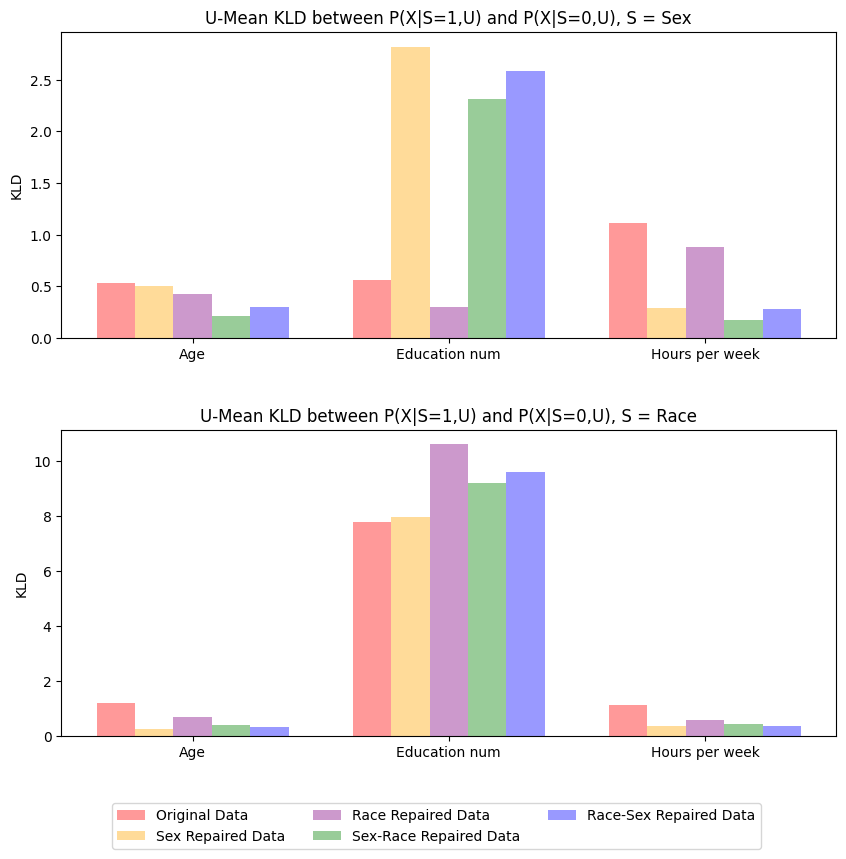

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
bar_width = 0.15
original_color = 'red'
s1_color = 'orange'
s2_color = 'purple'
s1_s2_color = 'green'
s2_s1_color = 'blue'

# First plot
kld_x_A_s1_mean = np.mean(kld_x_A_s1, axis=1)
kld_x_A_s2_mean = np.mean(kld_x_A_s2, axis=1)
kld_x_A_s1_s1_mean = np.mean(kld_x_A_s1_s1, axis=1)
kld_x_A_s1_s2_mean = np.mean(kld_x_A_s1_s2, axis=1)
kld_x_A_s2_s1_mean = np.mean(kld_x_A_s2_s1, axis=1)
kld_x_A_s2_s2_mean = np.mean(kld_x_A_s2_s2, axis=1)
kld_x_A_s1_s2_s1_mean = np.mean(kld_x_A_s1_s2_s1, axis=1)
kld_x_A_s1_s2_s2_mean = np.mean(kld_x_A_s1_s2_s2, axis=1)
kld_x_A_s2_s1_s1_mean = np.mean(kld_x_A_s2_s1_s1, axis=1)
kld_x_A_s2_s1_s2_mean = np.mean(kld_x_A_s2_s1_s2, axis=1)

pos = np.arange(len(kld_x_A_s1_mean))
original_bars = ax1.bar(x=pos - 2*bar_width, height=kld_x_A_s1_mean, width=bar_width, alpha=0.4, color=original_color)
s1_bars = ax1.bar(x=pos - bar_width, height=kld_x_A_s1_s1_mean, width=bar_width, alpha=0.4, color=s1_color)
s2_bars = ax1.bar(x=pos, height=kld_x_A_s2_s1_mean, width=bar_width, alpha=0.4, color=s2_color)
s1_s2_bars = ax1.bar(x=pos + bar_width, height=kld_x_A_s1_s2_s1_mean, width=bar_width, alpha=0.4, color=s1_s2_color)
s2_s1_bars = ax1.bar(x=pos + 2* bar_width, height=kld_x_A_s2_s1_s1_mean, width=bar_width, alpha=0.4, color=s2_s1_color)

x_labels = [feat.replace('-', ' ').capitalize() for feat in feats if feat not in plot_ignored_features]
ax1.set_xticks(pos)
ax1.set_xticklabels(x_labels)
ax1.set_ylabel("KLD")
ax1.set_title(f"U-Mean KLD between P(X|S=1,U) and P(X|S=0,U), S = {s1.title()}")

#add padding between the two plots
plt.subplots_adjust(hspace=0.3)

# Second plot
ax2.bar(x=pos - 2* bar_width, height=kld_x_A_s2_mean, width=bar_width, alpha=0.4, color=original_color)
ax2.bar(x=pos - bar_width, height=kld_x_A_s1_s2_mean, width=bar_width, alpha=0.4, color=s1_color)
ax2.bar(x=pos, height=kld_x_A_s2_s2_mean, width=bar_width, alpha=0.4, color=s2_color)
ax2.bar(x=pos + bar_width, height=kld_x_A_s1_s2_s2_mean, width=bar_width, alpha=0.4, color=s1_s2_color)
ax2.bar(x=pos + 2*bar_width, height=kld_x_A_s2_s1_s2_mean, width=bar_width, alpha=0.4, color=s2_s1_color)

ax2.set_xticks(pos)
ax2.set_xticklabels(x_labels)
ax2.set_ylabel("KLD")
ax2.set_title(f"U-Mean KLD between P(X|S=1,U) and P(X|S=0,U), S = {s2.title()}")

# Create a shared legend
handles = [original_bars, s1_bars, s2_bars, s1_s2_bars, s2_s1_bars]
labels = ['Original Data', f'{s1.title()} Repaired Data', f'{s2.title()} Repaired Data',
          f'{s1.title()}-{s2.title()} Repaired Data', f'{s2.title()}-{s1.title()} Repaired Data']
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3)

plt.subplots_adjust(bottom=0)
plt.show()